In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow

In [3]:
!pip install --upgrade tensorflow

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns

Dataset Preparation

In [5]:
# Load the dataset
column_names = ['Start', 'End', 'Open','High','Low', 'Close','Volume','Market Cap']
features = pd.read_csv('/content/drive/MyDrive/bitcoin_2010-07-27_2024-04-25.csv', names=column_names)

# Data cleaning
#features = features.drop(0)
features.drop(features.index[0], inplace=True)  # Drops the first row
features.reset_index(drop=True, inplace=True)
features.head(5)

,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2024-04-24,2024-04-25,66553.54,67070.4,63742.73,64291.07,138473620397.52264,1294488949358.7874
1,2024-04-23,2024-04-24,66761.02,67174.02,65884.15,66386.61,140862129941.0906,1308575919848.4077
2,2024-04-22,2024-04-23,64952.02,67180.03,64598,66818.89,140072513378.6934,1299703184791.7388
3,2024-04-21,2024-04-22,64875.75,65638.74,64302.47,64896.87,132657361139.69337,1278730196089.0593
4,2024-04-20,2024-04-21,63824.06,65351.33,63321.19,64857.99,153741041090.7073,1263724827950.2751


In [6]:
# Check for missing values
missing_values = features.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Start         0
End           0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64


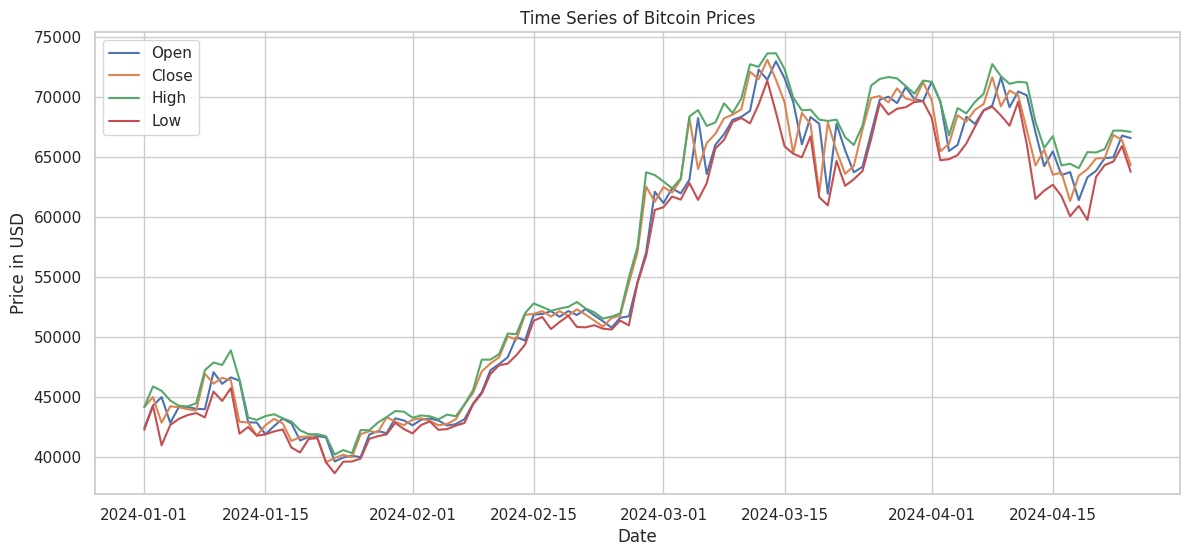

In [7]:
# Setting up the style
sns.set(style="whitegrid")

# Load your dataset here
# Adjust the path as needed
data = pd.read_csv('/content/drive/MyDrive/bitcoin_2010-07-27_2024-04-25.csv')
data['Start'] = pd.to_datetime(data['Start'])  # Ensure 'Start' is datetime
data = data[data['Start'].dt.year == 2024]  # Filter data for 2024

# Plotting Time Series of Prices
plt.figure(figsize=(14, 6))
plt.plot(data['Start'], data['Open'], label='Open')
plt.plot(data['Start'], data['Close'], label='Close')
plt.plot(data['Start'], data['High'], label='High')
plt.plot(data['Start'], data['Low'], label='Low')
plt.title('Time Series of Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()



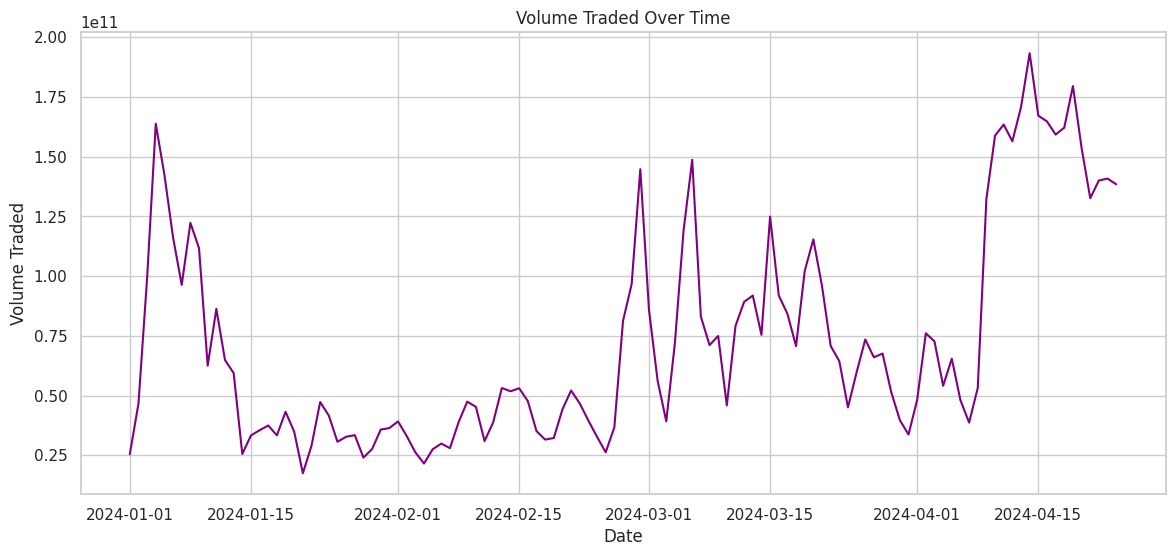

In [8]:
# Plotting Volume Traded Over Time
plt.figure(figsize=(14, 6))
plt.plot(data['Start'], data['Volume'], color='purple')
plt.title('Volume Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume Traded')
plt.show()

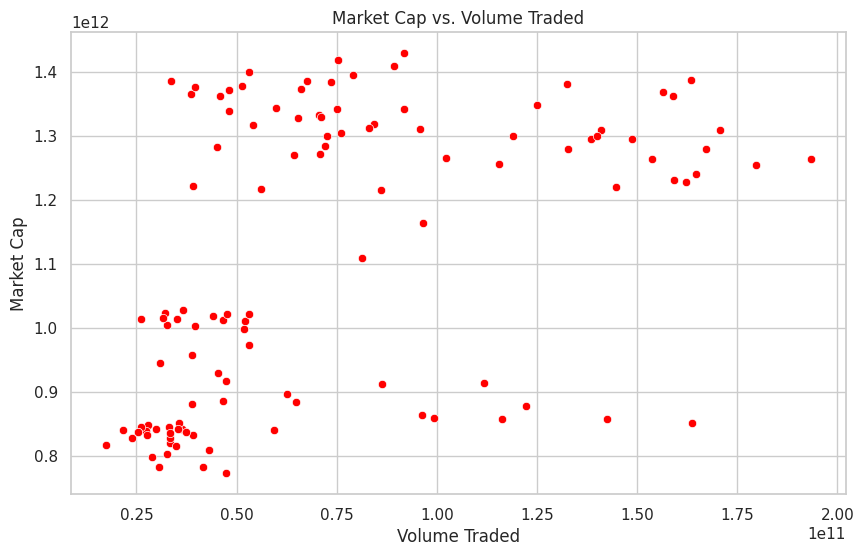

In [9]:
# Scatter Plot of Market Cap vs. Volume
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Volume', y='Market Cap', data=data, color='red')
plt.title('Market Cap vs. Volume Traded')
plt.xlabel('Volume Traded')
plt.ylabel('Market Cap')
plt.show()

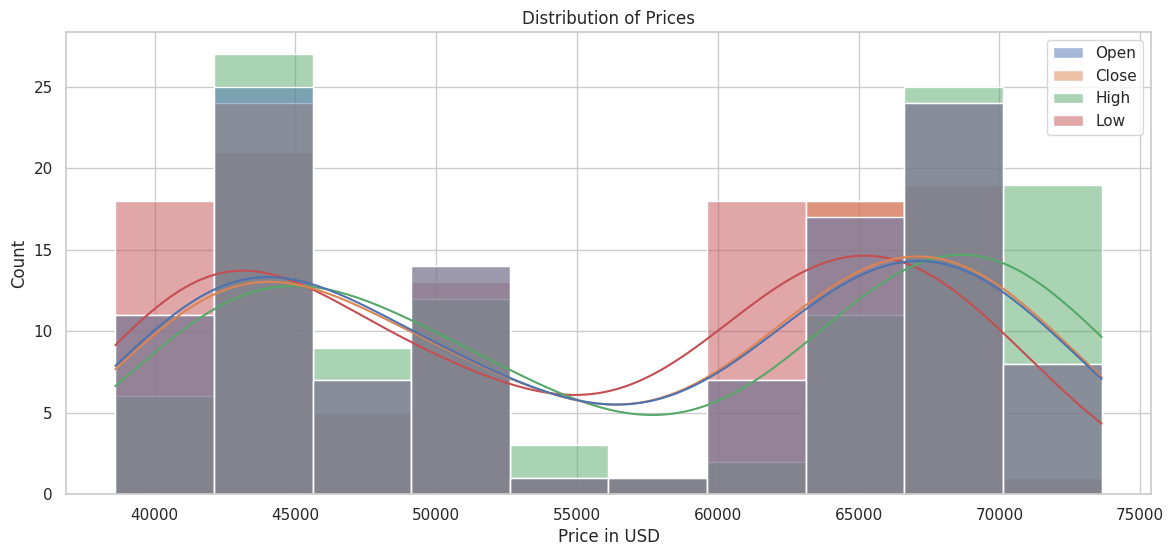

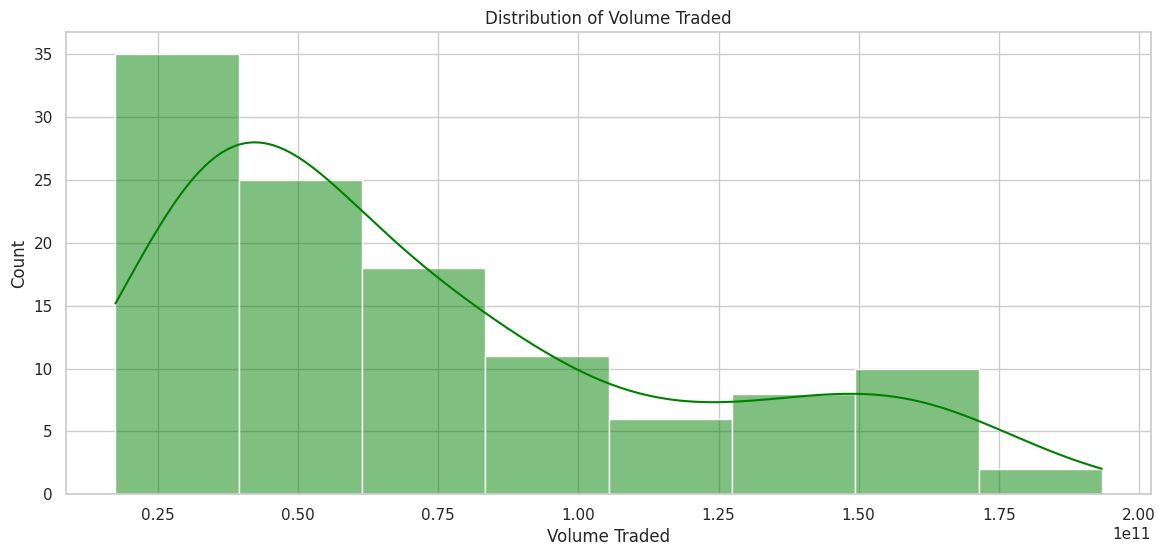

In [10]:
# Histograms of Prices and Volume
plt.figure(figsize=(14, 6))
sns.histplot(data[['Open', 'Close', 'High', 'Low']], kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price in USD')
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(data['Volume'], color='green', kde=True)
plt.title('Distribution of Volume Traded')
plt.xlabel('Volume Traded')
plt.show()

Data Preprocessing

In [11]:
# Perform Basic Statistical Analysis
# Showing basic statistics like mean, median, mode, standard deviation, and variance
print("\nBasic Statistical Analysis:")
print("Mean Values:")
print(data.mean(numeric_only=True))  # Mean of all numeric columns
print("\nMedian Values:")
print(data.median(numeric_only=True))  # Median of all numeric columns
print("\nMode Values:")
print(data.mode().iloc[0])  # Mode of all columns
print("\nStandard Deviation:")
print(data.std(numeric_only=True))  # Standard deviation of all numeric columns
print("\nVariance:")
print(data.var(numeric_only=True))  # Variance of all numeric columns



Basic Statistical Analysis:
Mean Values:
Open          5.607708e+04
High          5.735552e+04
Low           5.485564e+04
Close         5.628909e+04
Volume        7.363118e+10
Market Cap    1.103151e+12
dtype: float64

Median Values:
Open          5.456001e+04
High          5.750114e+04
Low           5.446373e+04
Close         5.702924e+04
Volume        5.620825e+10
Market Cap    1.109066e+12
dtype: float64

Mode Values:
Start         2024-01-01 00:00:00
End                    2024-01-02
Open                     39588.08
High                     40166.68
Low                      38604.83
Close                    39516.98
Volume         17447807044.027874
Market Cap    773218301080.630615
Name: 0, dtype: object

Standard Deviation:
Open          1.136038e+04
High          1.169976e+04
Low           1.087542e+04
Close         1.133934e+04
Volume        4.540606e+10
Market Cap    2.235578e+11
dtype: float64

Variance:
Open          1.290583e+08
High          1.368844e+08
Low           1.

In [12]:
# Ensure we exclude non-numeric columns explicitly if they exist
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Check what columns are being included in the correlation matrix
print("Columns included in the correlation matrix:", numeric_data.columns)

# Calculate and print the correlation matrix
print("\nCorrelation Matrix:")
print(numeric_data.corr())

Columns included in the correlation matrix: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

Correlation Matrix:
                Open      High       Low     Close    Volume  Market Cap
Open        1.000000  0.994468  0.992254  0.986723  0.481759    0.996302
High        0.994468  1.000000  0.991931  0.995430  0.486955    0.997853
Low         0.992254  0.991931  1.000000  0.994201  0.444199    0.996893
Close       0.986723  0.995430  0.994201  1.000000  0.464165    0.995605
Volume      0.481759  0.486955  0.444199  0.464165  1.000000    0.475329
Market Cap  0.996302  0.997853  0.996893  0.995605  0.475329    1.000000


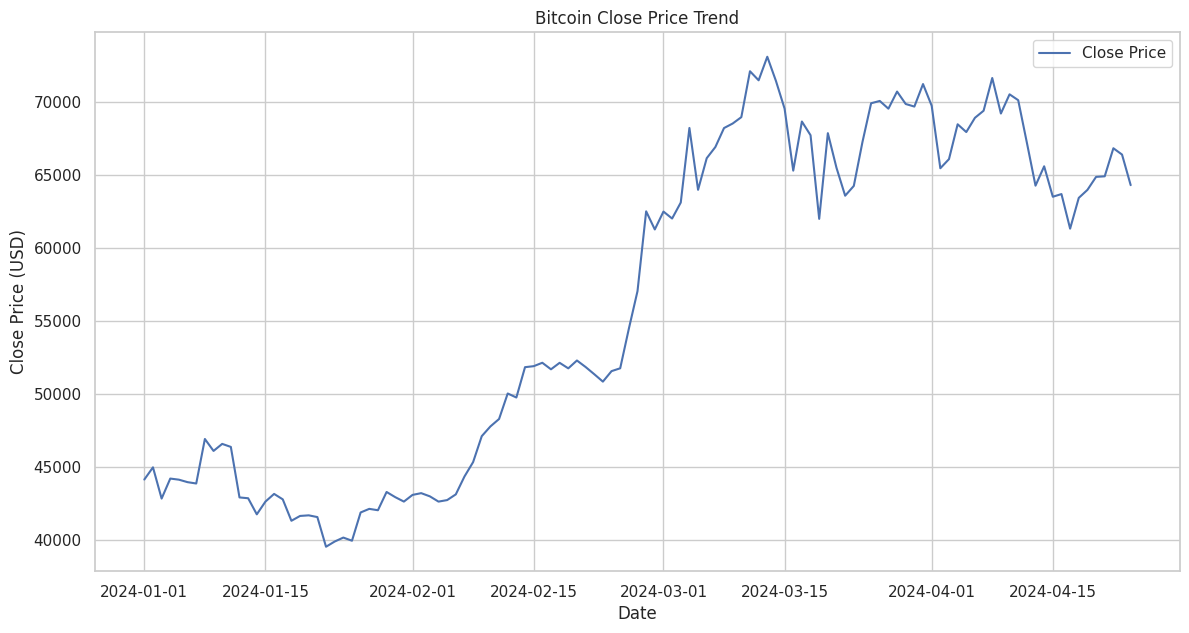

In [13]:
# Set the date as the index
data.set_index('Start', inplace=True)

# Trend Analysis
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title('Bitcoin Close Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

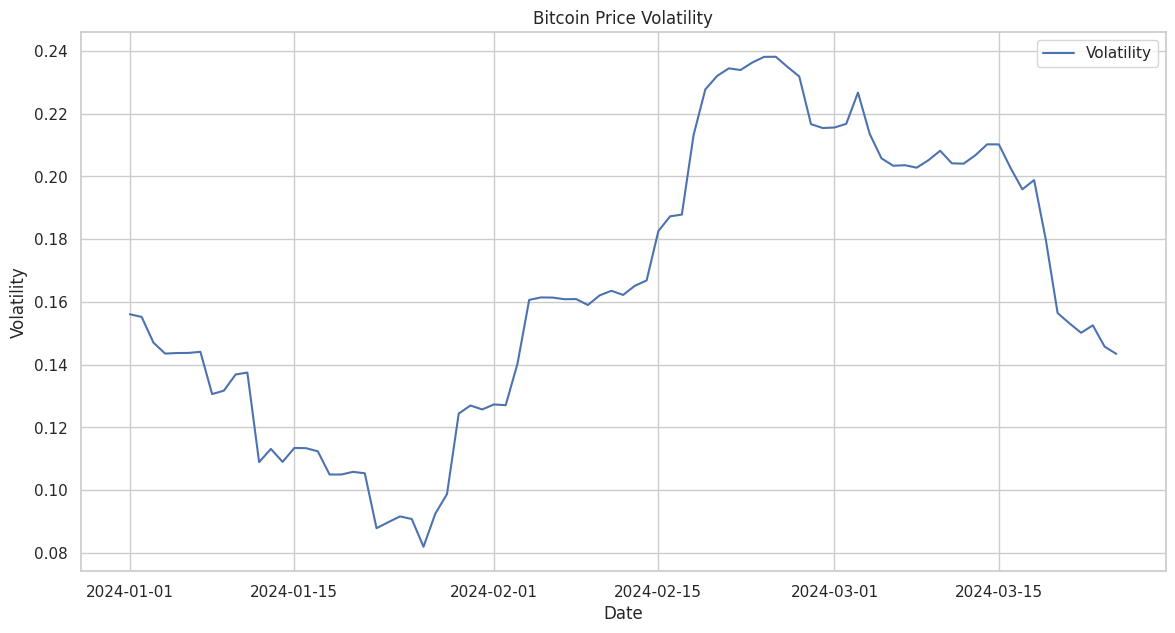

In [14]:
# Volatility Analysis
data['Daily Returns'] = data['Close'].pct_change()
data['Volatility'] = data['Daily Returns'].rolling(window=30).std() * np.sqrt(30)

plt.figure(figsize=(14, 7))
plt.plot(data['Volatility'], label='Volatility')
plt.title('Bitcoin Price Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [20]:
# Display the shape of the dataset
print("Dataset has", data.shape[0], "rows and", data.shape[1], "columns.")

Dataset has 115 rows and 9 columns.


In [23]:
# Importing necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Split the data into training and testing sets with 20% allocated to testing
train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length (number of time steps)
seq_length = 10

# Create sequences for training and testing sets
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Print the shapes of training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (82, 10, 1)
X_test shape: (13, 10, 1)
y_train shape: (82, 1)
y_test shape: (13, 1)


Model Development

In [25]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

#Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.3841 - val_loss: 0.2162
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2585 - val_loss: 0.1475
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1750 - val_loss: 0.1141
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1136 - val_loss: 0.1302
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1304 - val_loss: 0.1610
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1359 - val_loss: 0.1470
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1176 - val_loss: 0.1244
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1186 - val_loss: 0.1150
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1125 - val_loss: 0.1140
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1195 - val_loss: 0.1141
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1181 - val_loss: 0.1140
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1136 - val_l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

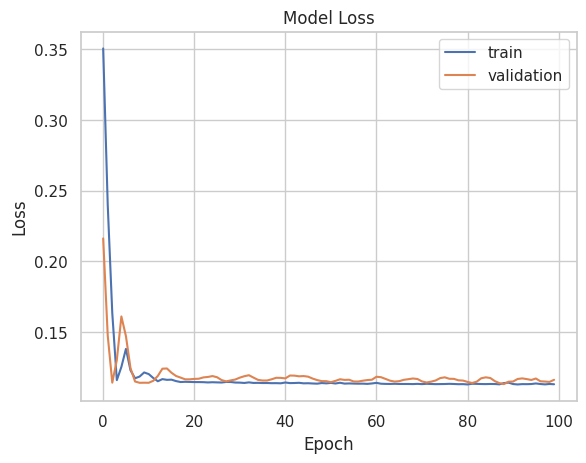

In [26]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Model Evaluation

Train Loss: 0.11284786462783813
Test Loss: 0.11615628749132156


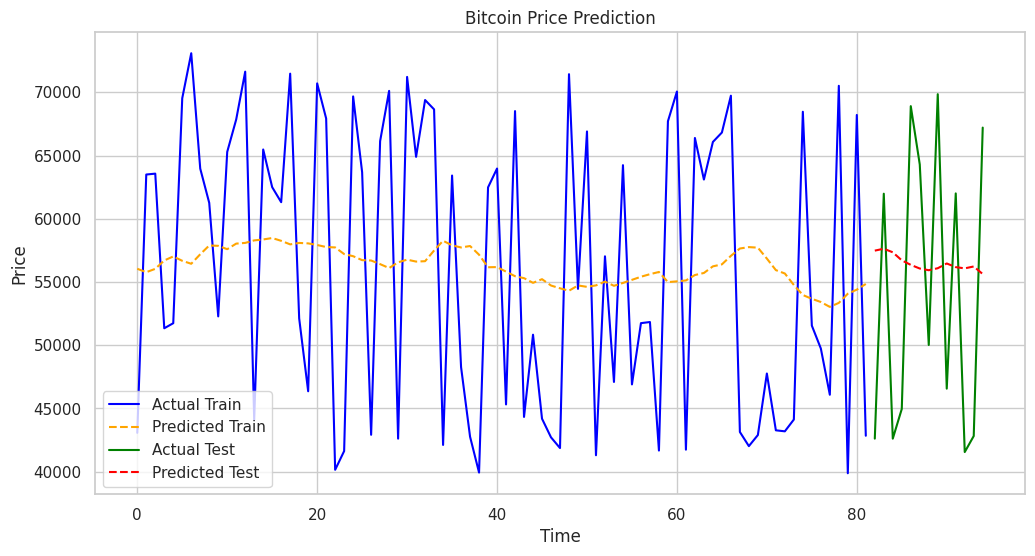

In [30]:
# Evaluate the model
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

print("Train Loss:", train_score)
print("Test Loss:", test_score)

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Actual Train', color='blue')
plt.plot(np.arange(len(train_predictions)), train_predictions, label='Predicted Train', linestyle='dashed', color='orange')

# Plot testing data
plt.plot(np.arange(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), y_test_inv, label='Actual Test', color='green')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv) + len(test_predictions)), test_predictions, label='Predicted Test', linestyle='dashed', color='red')

plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Visualization of Model Predictions and Error Analysis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


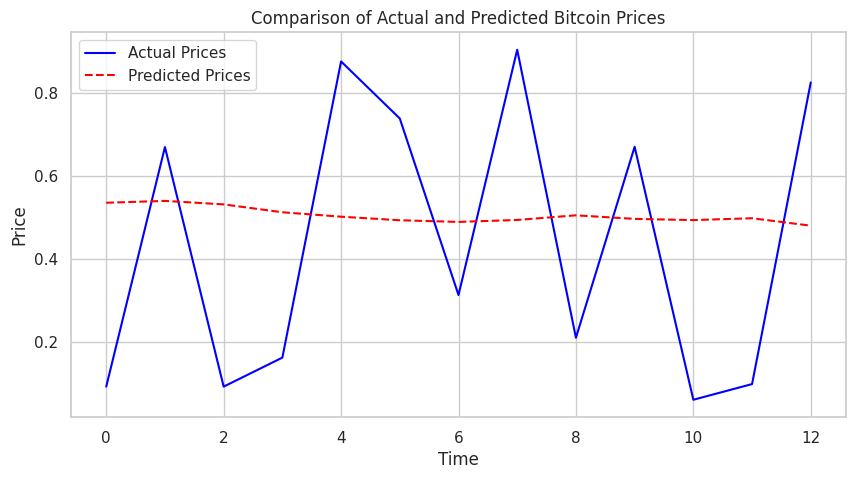

In [32]:
# Generate predictions
predictions = model.predict(X_test)

# Plotting Predictions vs Actual Prices
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Bitcoin Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

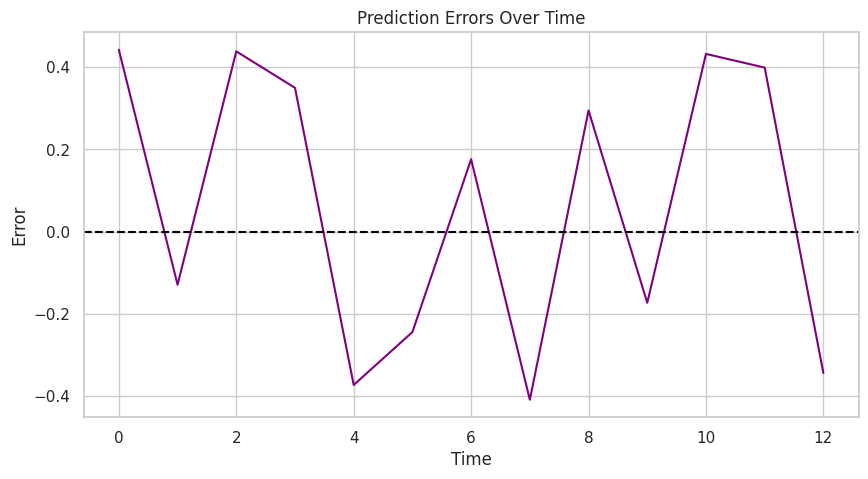

In [36]:
# Error Analysis - Plotting prediction errors over time
errors = predictions.flatten() - y_test.flatten()
plt.figure(figsize=(10, 5))
plt.plot(errors, color='purple')
plt.title('Prediction Errors Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='black', linestyle='--')  # Line at 0 error
plt.show()

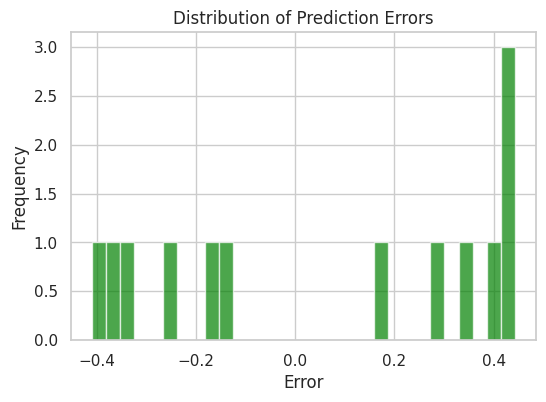

In [34]:
# Optionally, visualize error distribution
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()